In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import monotonically_increasing_id

In [2]:
# Initialize a SparkSession
spark = SparkSession.builder.appName("exampleApp").master("local").getOrCreate()

In [3]:
# Load the CSV file into a DataFrame
data = spark.read.format('csv').options(header='true', inferSchema='true').load('w3_clustering.csv')

In [4]:
# Add an index column to the original data
data = data.withColumn("index", monotonically_increasing_id())

In [5]:
# Feature assembly
featuresUsed = ['totalAdClicks', 'revenue']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(data)

In [6]:
# Feature scaling
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)
scaledData = scaledData.select("features", "index")  # Include the index column for joining
scaledData.persist()

DataFrame[features: vector, index: bigint]

In [7]:
# K-means clustering
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(scaledData)
transformed = model.transform(scaledData)

In [8]:
# Evaluate the model using ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(transformed)
print(f"Silhouette with squared euclidean distance = {silhouette}")

Silhouette with squared euclidean distance = 0.5663996702249793


In [9]:
# Assign cluster labels to the original data by joining on the index column
data_with_clusters = data.join(transformed.select("index", "prediction"), on="index")
data_with_clusters.show(truncate=False)

+-----+-------------+-------+----------+
|index|totalAdClicks|revenue|prediction|
+-----+-------------+-------+----------+
|0    |22           |12.0   |1         |
|1    |20           |11.0   |1         |
|2    |53           |51.0   |0         |
|3    |48           |61.0   |0         |
|4    |23           |3.0    |1         |
|5    |14           |25.0   |1         |
|6    |34           |90.0   |0         |
|7    |3            |13.0   |1         |
|8    |24           |12.0   |1         |
|9    |5            |4.0    |1         |
|10   |34           |75.0   |0         |
|11   |43           |35.0   |0         |
|12   |53           |49.0   |0         |
|13   |20           |2.0    |1         |
|14   |14           |6.0    |1         |
|15   |10           |8.0    |1         |
|16   |36           |27.0   |1         |
|17   |16           |6.0    |1         |
|18   |16           |70.0   |1         |
|19   |21           |8.0    |1         |
+-----+-------------+-------+----------+
only showing top

In [10]:

# Display the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.84174521 0.51884657]
[-0.79780796 -0.49176392]


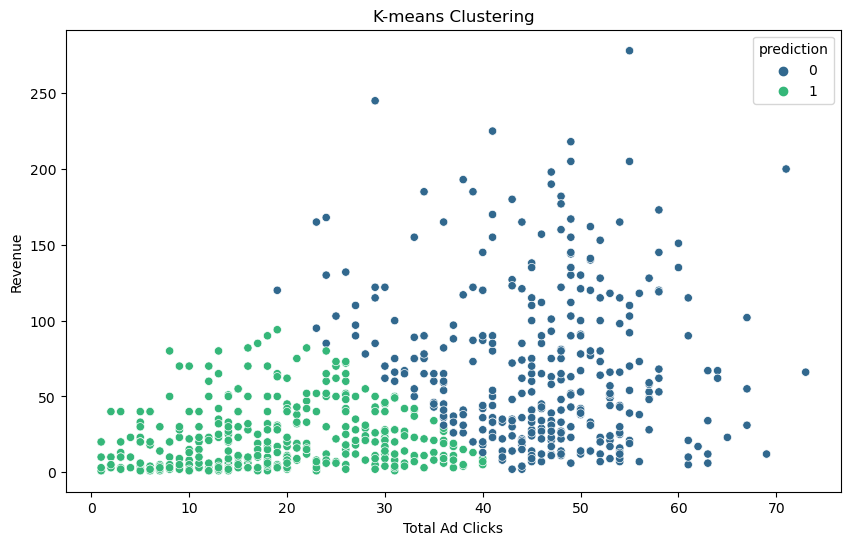

In [11]:
# Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = data_with_clusters.toPandas()

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='totalAdClicks', y='revenue', hue='prediction', data=pandas_df, palette='viridis')
plt.title('K-means Clustering')
plt.xlabel('Total Ad Clicks')
plt.ylabel('Revenue')
plt.show()
